In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
deaths_age = pd.read_csv('BE0101D8_20201216-204712.csv').set_index('age')

In [3]:
deaths_age.head()

,2014,2015,2016,2017,2018,2019
age,,,,,,
0-4 years,299,333,344,322,302,289
5-9 years,44,41,54,40,34,36
10-14 years,32,51,41,44,51,36
15-19 years,113,109,102,124,133,122
20-24 years,288,290,229,251,272,246


In [4]:
pop_age = pd.read_csv('BE0101C£_20201216-232934.csv')
pop_age = pop_age.drop(columns='age')

pop_age_agg = pd.concat([pop_age.iloc[0:65].sum(), pop_age.iloc[65:80].sum(),  pop_age.iloc[80:90].sum(), pop_age.iloc[90:].sum()], axis=1)
pop_age_agg = pop_age_agg.rename(columns={0:'0-64',1:'65-79', 2:'80-89', 3:'90+'})
pop_age_agg.loc['2020'] = np.nan
pop_age_agg = pop_age_agg.shift()
pop_age_agg['total'] = pop_age_agg.sum(axis=1)
pop_age_agg.tail()

,0-64,65-79,80-89,90+,total
2016,7903790.0,1445577.0,405287.0,96363.0,9851017.0
2017,8018296.0,1469963.0,409775.0,97119.0,9995153.0
2018,8114096.0,1493476.0,415286.0,97384.0,10120242.0
2019,8194474.0,1513578.0,423830.0,98303.0,10230185.0
2020,8262222.0,1529061.0,436679.0,99627.0,10327589.0


In [5]:
deaths_age = pd.read_csv('BE0101D8_20201217-174639.csv')
deaths_age = deaths_age.drop(columns='age')
deaths_age_agg = pd.concat([deaths_age.iloc[0:65].sum(), deaths_age.iloc[65:80].sum(),  deaths_age.iloc[80:90].sum(), deaths_age.iloc[90:].sum()], axis=1)
deaths_age_agg = deaths_age_agg.rename(columns={0:'0-64',1:'65-79', 2:'80-89', 3:'90+'})

####
deaths_2020 = pd.read_excel('2020-12-21-preliminar_statistik_over_doda_inkl_eng.xlsx', sheet_name = 'Tabell 2', skiprows = range(0,6), engine='openpyxl')

deaths_2020['0-64'] = deaths_2020['0-64 år.2'] + deaths_2020['0-64 år.3']
deaths_2020['65-79'] = deaths_2020['65-79 år.2'] + deaths_2020['65-79 år.3']
deaths_2020['80-89'] = deaths_2020['80-89 år.2'] + deaths_2020['80-89 år.3']
deaths_2020['90+'] = deaths_2020['90+ år.2'] + deaths_2020['90+ år.3']

#estimate december 2020 deaths
deaths_2020 = deaths_2020.drop(0)
december_values = deaths_2020.set_index('Unnamed: 22').loc['december'][['0-64', '65-79', '80-89', '90+']].iloc[0:7].mean().astype(int)
deaths_2020 = deaths_2020.groupby('Unnamed: 22')[['0-64', '65-79', '80-89', '90+']].sum()
deaths_2020.loc['december'] = december_values*31

###
deaths_age_agg.loc['2020'] = deaths_2020.sum()
deaths_age_agg['total'] = deaths_age_agg.sum(axis=1)
deaths_age_agg.tail()

,0-64,65-79,80-89,90+,total
2016,10410,25474,30791,24307,90982
2017,10260,25601,31333,24778,91972
2018,10172,26233,31238,24542,92185
2019,9757,25393,30220,23396,88766
2020,9295,27183,33921,23983,94382


In [6]:
deaths_2020.sum(axis=1)

Unnamed: 22
april        10375
augusti       6788
december      9207
februari      7366
januari       7868
juli          6850
juni          7238
maj           8706
mars          8371
november      7974
oktober       7053
september     6586
dtype: int64

In [7]:
deaths_age_adj = (deaths_age_agg/pop_age_agg)*pop_age_agg.loc['2019']
deaths_age_adj['total'] = deaths_age_adj['0-64'] + deaths_age_adj['65-79'] + deaths_age_adj['80-89'] + deaths_age_adj['90+']

In [8]:
deaths_age_adj['total/million'] = deaths_age_adj['total']/(pop_age_agg['total'].loc['2019']/1000000)

deaths_age_adj.tail()

,0-64,65-79,80-89,90+,total,total/million
2016,10792.856888,26672.315603,32199.773321,24796.353590,94461.299402,9233.586626
2017,10485.432720,26360.602531,32407.700299,25080.074280,94333.809830,9221.124528
2018,10272.763537,26586.092896,31880.683529,24773.599626,93513.139589,9140.904059
2019,9757.000000,25393.000000,30220.000000,23396.000000,88766.000000,8676.871435
2020,9218.783498,26907.749772,32922.896292,23664.276240,92713.705802,9062.759452


In [9]:
window1 = 5
window2 = 3
deaths_age_adj['5 year trendline'] = deaths_age_adj['total/million'].shift().rolling(window = window1).apply(lambda x: np.polyval(np.polyfit(np.array(range(0,window1)), x, 1), window1), raw=True)
deaths_age_adj['3 year mean'] = deaths_age_adj['total/million'].rolling(window2).mean().shift()

deaths_age_adj['excess1'] = deaths_age_adj['total/million'] - deaths_age_adj['5 year trendline']
deaths_age_adj['excess2'] = deaths_age_adj['total/million'] - deaths_age_adj['3 year mean']

In [10]:
deaths_age_adj.sort_values(by = 'excess1', ascending=False)#.iloc[0:20]

,0-64,65-79,80-89,90+,total,total/million,5 year trendline,3 year mean,excess1,excess2
1985,18983.019142,49673.185001,48948.024758,30148.180783,147752.409684,14442.789616,13773.316973,14364.835147,669.472642,77.954469
1993,15754.737664,43287.185858,45181.790294,29620.093569,133843.807384,13083.224534,12671.482591,13162.838863,411.741943,-79.614329
2020,9218.783498,26907.749772,32922.896292,23664.276240,92713.705802,9062.759452,8698.628115,9012.966674,364.131336,49.792778
1988,18312.757192,47043.751848,48394.635233,30063.643358,143814.787631,14057.887285,13746.800327,14081.742281,311.086957,-23.854996
1976,22753.211779,55234.700654,55915.605583,32854.447907,166757.965924,16300.581654,16015.791633,16197.548287,284.790021,103.033367
2007,13499.663214,31928.226891,36696.220394,26528.559374,108652.669874,10620.792280,10347.889251,10774.751157,272.903030,-153.958877
1980,21427.142542,51855.434232,52401.978287,30639.444099,156323.999161,15280.661998,15012.212592,15414.923619,268.449406,-134.261621
1990,17078.893686,44752.247769,45977.302086,29013.168126,136821.611667,13374.304733,13155.005367,13671.673126,219.299366,-297.368393
2015,10987.716895,26826.176077,32768.297207,24921.377205,95503.567384,9335.468262,9126.327914,9534.855356,209.140348,-199.387093
1996,14539.415690,40350.260267,42301.421530,27950.467219,125141.564706,12232.580809,12028.717177,12547.096493,203.863632,-314.515684


In [11]:
deaths_age_adj.sort_values(by = 'excess2', ascending=False).iloc[0:10]

,0-64,65-79,80-89,90+,total,total/million,5 year trendline,3 year mean,excess1,excess2
1976,22753.211779,55234.700654,55915.605583,32854.447907,166757.965924,16300.581654,16015.791633,16197.548287,284.790021,103.033367
1985,18983.019142,49673.185001,48948.024758,30148.180783,147752.409684,14442.789616,13773.316973,14364.835147,669.472642,77.954469
2020,9218.783498,26907.749772,32922.896292,23664.276240,92713.705802,9062.759452,8698.628115,9012.966674,364.131336,49.792778
1973,22947.998413,56033.189800,56509.907829,31897.296082,167388.392123,16362.205779,NaN,16346.138982,NaN,16.066797
1988,18312.757192,47043.751848,48394.635233,30063.643358,143814.787631,14057.887285,13746.800327,14081.742281,311.086957,-23.854996
2017,10485.432720,26360.602531,32407.700299,25080.074280,94333.809830,9221.124528,9032.097004,9278.172453,189.027524,-57.047925
1999,14212.467135,39102.918893,41423.353102,27813.816404,122552.555534,11979.505310,11835.250259,12044.627463,144.255051,-65.122152
1993,15754.737664,43287.185858,45181.790294,29620.093569,133843.807384,13083.224534,12671.482591,13162.838863,411.741943,-79.614329
2018,10272.763537,26586.092896,31880.683529,24773.599626,93513.139589,9140.904059,9120.850320,9263.393139,20.053739,-122.489080
1980,21427.142542,51855.434232,52401.978287,30639.444099,156323.999161,15280.661998,15012.212592,15414.923619,268.449406,-134.261621


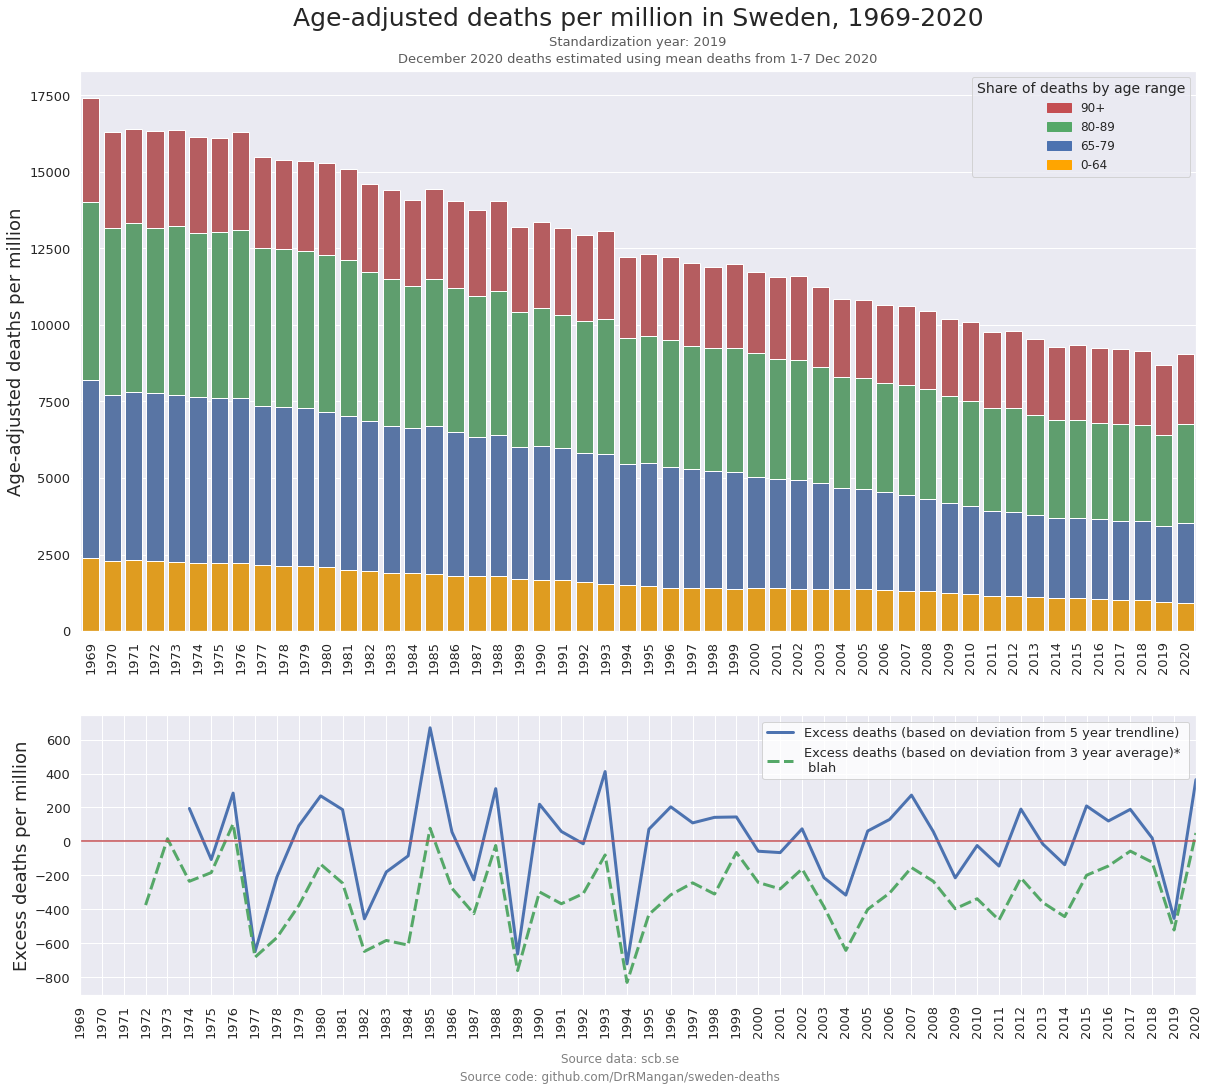

In [12]:
import matplotlib.patches as mpatches

sns.set_theme(style="darkgrid")

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, figsize = (20,17))

pop_millions = pop_age_agg.loc['2019']['total']/1000000
axs[0] = sns.barplot(x=deaths_age_adj['total'].iloc[1:].index, y=(deaths_age_adj['0-64'].iloc[1:] + deaths_age_adj['65-79'].iloc[1:] + deaths_age_adj['80-89'].iloc[1:] + deaths_age_adj['90+'].iloc[1:])/pop_millions, color="r", ax=axs[0])
axs[0] = sns.barplot(x=deaths_age_adj['total'].iloc[1:].index, y=(deaths_age_adj['0-64'].iloc[1:] + deaths_age_adj['65-79'].iloc[1:] + deaths_age_adj['80-89'].iloc[1:])/pop_millions, color="g", ax=axs[0])
axs[0] = sns.barplot(x=deaths_age_adj['total'].iloc[1:].index, y=(deaths_age_adj['0-64'].iloc[1:] + deaths_age_adj['65-79'].iloc[1:])/pop_millions, color="b", ax=axs[0])
axs[0] = sns.barplot(x=deaths_age_adj['total'].iloc[1:].index, y=(deaths_age_adj['0-64'].iloc[1:])/pop_millions, color="orange", ax=axs[0])
red_patch = mpatches.Patch(color='r', label='90+')
green_patch = mpatches.Patch(color='g', label='80-89')
blue_patch = mpatches.Patch(color='b', label='65-79')
orange_patch = mpatches.Patch(color='orange', label='0-64')

axs[0].legend(handles=[red_patch, green_patch, blue_patch, orange_patch], title='Share of deaths by age range', title_fontsize=14, fontsize=12)

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title('Age-adjusted deaths per million in Sweden, 1969-2020', fontsize=25, y=1.07)
axs[0].text(x=0.5, y=1.04, s='Standardization year: 2019', fontsize=13, alpha=0.75, ha='center', va='bottom', transform=axs[0].transAxes)
axs[0].text(x=0.5, y=1.01, s='December 2020 deaths estimated using mean deaths from 1-7 Dec 2020', fontsize=13, alpha=0.75, ha='center', va='bottom', transform=axs[0].transAxes)
axs[0].set_ylabel('Age-adjusted deaths per million', fontsize=18)
axs[0].tick_params(axis='both', labelsize=13)

sns.set_style("ticks")

axs[1] = sns.lineplot(data=deaths_age_adj[['excess1', 'excess2']], palette=['C0', 'C2'], ax=axs[1], linewidth=3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xticks(rotation=90)
axs[1].set_xlim(left=1, right=52)
axs[1].set_ylabel('Excess deaths per million', fontsize=18)
axs[1].tick_params(axis='both', labelsize=13)

plt.legend(labels=['Excess deaths (based on deviation from 5 year trendline)', 'Excess deaths (based on deviation from 3 year average)* \n blah'], fontsize=13)

plt.figtext(0.5, 0.07, "Source data: scb.se", color='gray', ha="center", fontsize=12)
plt.figtext(0.5, 0.055, "Source code: github.com/DrRMangan/sweden-deaths", color='gray', ha="center", fontsize=12)

fig.savefig('sweden.png')

In [13]:
deaths_age_agg_2year = deaths_age_agg + deaths_age_agg.shift()
deaths_age_adj_2year = (deaths_age_agg_2year/pop_age_agg)*pop_age_agg.loc['2020']
deaths_age_adj_2year['total'] = deaths_age_adj_2year['0-64'] + deaths_age_adj_2year['65-79'] + deaths_age_adj_2year['80-89'] + deaths_age_adj_2year['90+']
deaths_age_adj_2year['total/million'] = deaths_age_adj_2year['total']/(pop_age_agg['total'].loc['2020']/1000000)
deaths_age_adj_2year

,0-64,65-79,80-89,90+,total,total/million
1968,NaN,NaN,NaN,NaN,NaN,NaN
1969,48978.895489,118728.544100,123625.267601,69500.840135,360833.547326,34938.798138
1970,48221.287352,114846.252852,117492.363307,65380.218750,345940.122262,33496.697270
1971,47475.829710,111568.142074,113657.860611,62530.644943,335232.477337,32459.897207
1972,47516.090365,112367.471112,112677.413056,63246.021054,335806.995586,32515.526672
1973,46841.514375,112233.441189,113352.415915,63939.375194,336366.746673,32569.726262
1974,46207.446517,111418.632693,112652.059518,62913.568584,333191.707313,32262.293485
1975,46085.801040,110454.599323,111646.535180,62229.387417,330416.322961,31993.558512
1976,45993.086506,110426.761175,112905.768329,63314.619343,332640.235353,32208.895547
1977,45301.255346,108393.562067,110484.267335,62999.958848,327179.043596,31680.099159


In [14]:
new_index = deaths_age_adj_2year.iloc[1::2].index + '/' + deaths_age_adj_2year.iloc[2::2].index
deaths_age_adj_2year = deaths_age_adj_2year.iloc[2::2]
deaths_age_adj_2year.index = new_index
deaths_age_adj_2year

,0-64,65-79,80-89,90+,total,total/million
1969/1970,48221.287352,114846.252852,117492.363307,65380.218750,345940.122262,33496.697270
1971/1972,47516.090365,112367.471112,112677.413056,63246.021054,335806.995586,32515.526672
1973/1974,46207.446517,111418.632693,112652.059518,62913.568584,333191.707313,32262.293485
1975/1976,45993.086506,110426.761175,112905.768329,63314.619343,332640.235353,32208.895547
1977/1978,44186.024204,106286.370996,107348.824297,59275.044453,317096.263950,30703.803564
1979/1980,43574.335627,105018.422489,106458.868135,60501.258812,315552.885063,30554.361242
1981/1982,40999.848996,102321.405636,103212.313853,59084.691347,305618.259833,29592.411146
1983/1984,39168.245924,98410.391146,97963.702054,57847.302498,293389.641622,28408.338250
1985/1986,37725.554753,97747.175911,98624.858204,58894.226558,292991.815425,28369.817527
1987/1988,36882.953107,94459.565680,96794.910715,58364.881147,286502.310649,27741.451625


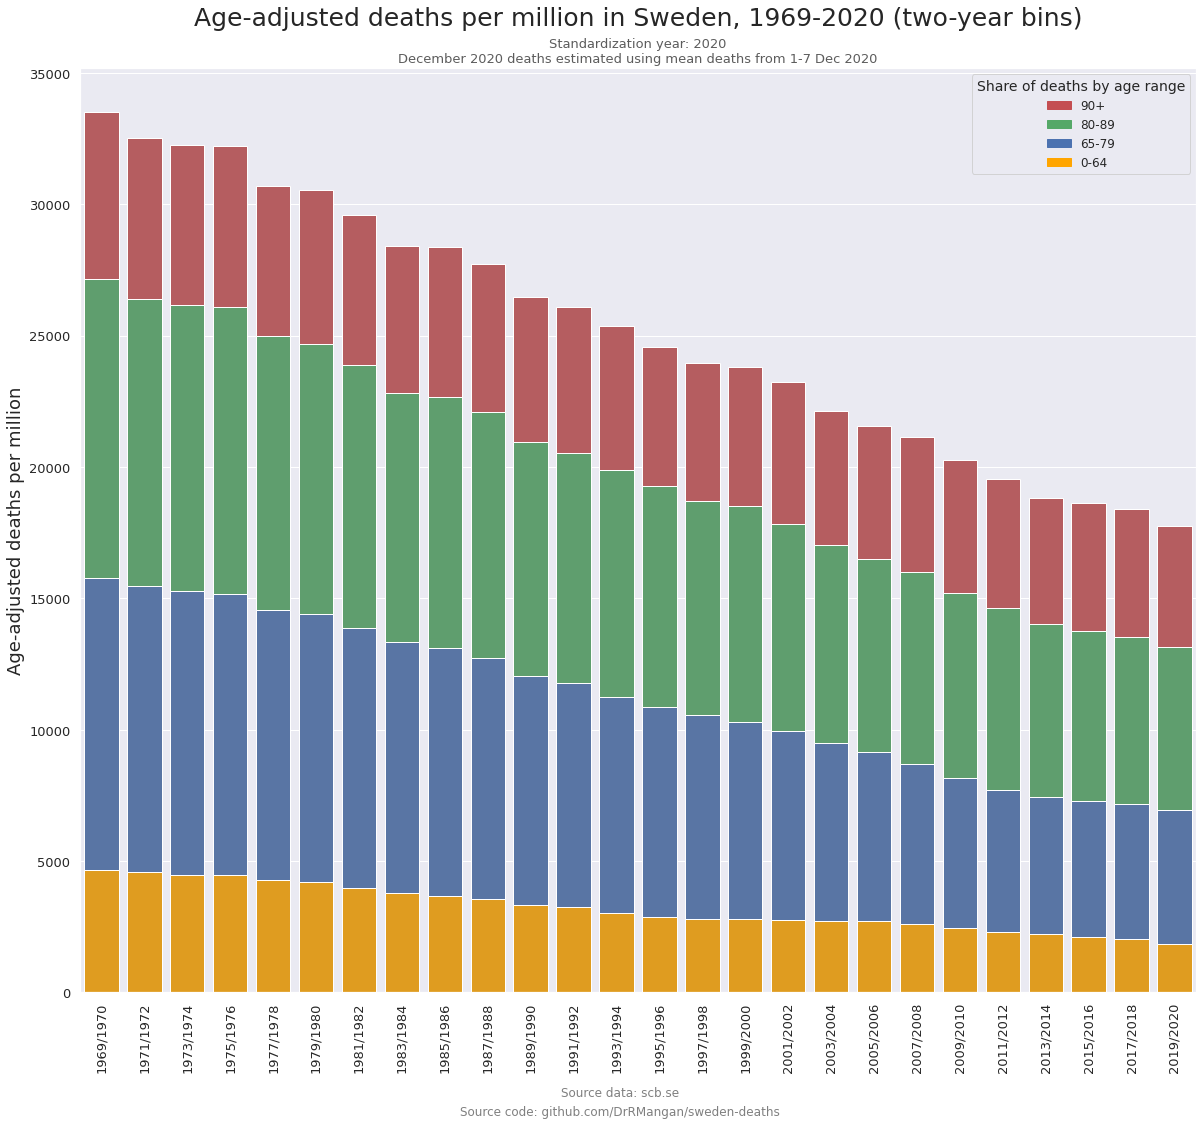

In [15]:
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots( figsize = (20,17))

pop_millions = pop_age_agg.loc['2020']['total']/1000000
ax = sns.barplot(x=deaths_age_adj_2year['total'].index, y=(deaths_age_adj_2year['0-64'] + deaths_age_adj_2year['65-79'] + deaths_age_adj_2year['80-89'] + deaths_age_adj_2year['90+'])/pop_millions, color="r", ax=ax)
ax = sns.barplot(x=deaths_age_adj_2year['total'].index, y=(deaths_age_adj_2year['0-64'] + deaths_age_adj_2year['65-79'] + deaths_age_adj_2year['80-89'])/pop_millions, color="g", ax=ax)
ax = sns.barplot(x=deaths_age_adj_2year['total'].index, y=(deaths_age_adj_2year['0-64'] + deaths_age_adj_2year['65-79'])/pop_millions, color="b", ax=ax)
ax = sns.barplot(x=deaths_age_adj_2year['total'].index, y=(deaths_age_adj_2year['0-64'])/pop_millions, color="orange", ax=ax)
red_patch = mpatches.Patch(color='r', label='90+')
green_patch = mpatches.Patch(color='g', label='80-89')
blue_patch = mpatches.Patch(color='b', label='65-79')
orange_patch = mpatches.Patch(color='orange', label='0-64')

ax.legend(handles=[red_patch, green_patch, blue_patch, orange_patch], title='Share of deaths by age range', title_fontsize=14, fontsize=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Age-adjusted deaths per million in Sweden, 1969-2020 (two-year bins)', fontsize=25, y=1.04)
ax.text(x=0.5, y=1.02, s='Standardization year: 2020', fontsize=13, alpha=0.75, ha='center', va='bottom', transform = ax.transAxes)
ax.text(x=0.5, y=1.003, s='December 2020 deaths estimated using mean deaths from 1-7 Dec 2020', fontsize=13, alpha=0.75, ha='center', va='bottom', transform = ax.transAxes)
ax.set_ylabel('Age-adjusted deaths per million', fontsize=18)
ax.tick_params(axis='both', labelsize=13)

plt.figtext(0.5, 0.04, "Source data: scb.se", color='gray', ha="center", fontsize=12)
plt.figtext(0.5, 0.025, "Source code: github.com/DrRMangan/sweden-deaths", color='gray', ha="center", fontsize=12)

fig.savefig('sweden2.png', bbox_inches='tight')